In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rc(
    "figure",
    figsize=(16, 8),
)
%config InlineBackend.figure_format = 'retina'

cap = cv2.VideoCapture("dashcam1.webm")

cap.set(cv2.CAP_PROP_POS_FRAMES, 20)

frames = []
for i in range(10):
    ret, frame1 = cap.read()
    h, w, c = frame1.shape
    frames.append(frame1[:, :, ::-1])

cap.release()

frames = np.array(frames)

frames.shape

(10, 1440, 2560, 3)

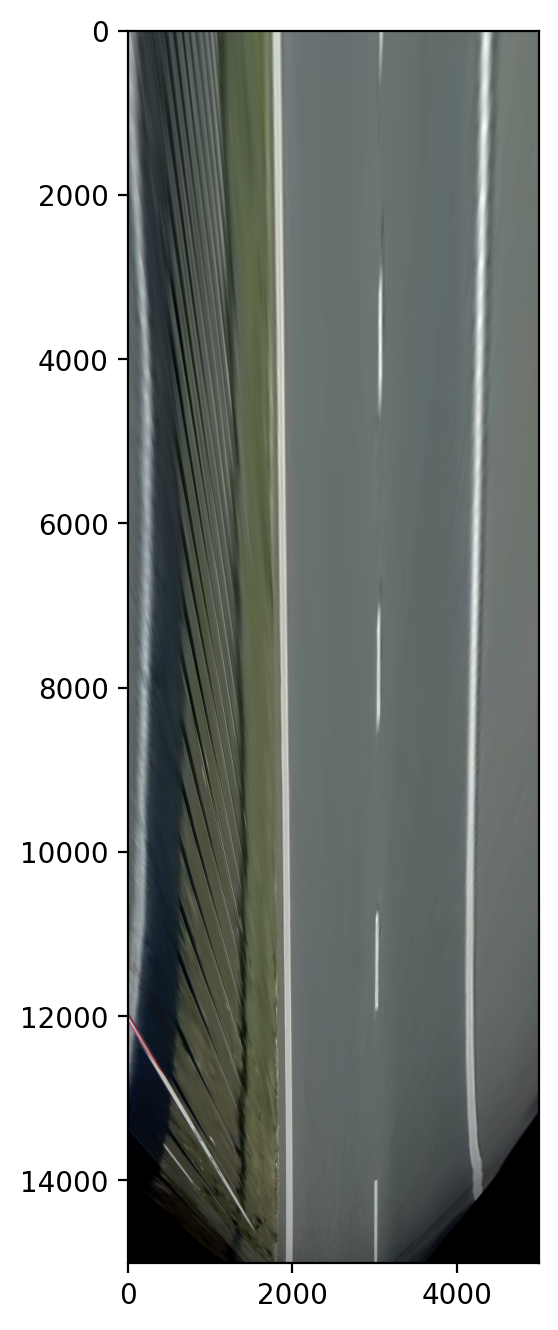

In [80]:
from lib.perspective import PerspectiveTransformation

pt = PerspectiveTransformation()

bew_frames = []
for frame in frames:
    bew_frames.append(pt.get_bird_eye_view(frame))

bew_frames = np.array(bew_frames)

plt.imshow(bew_frames[0])

uint8


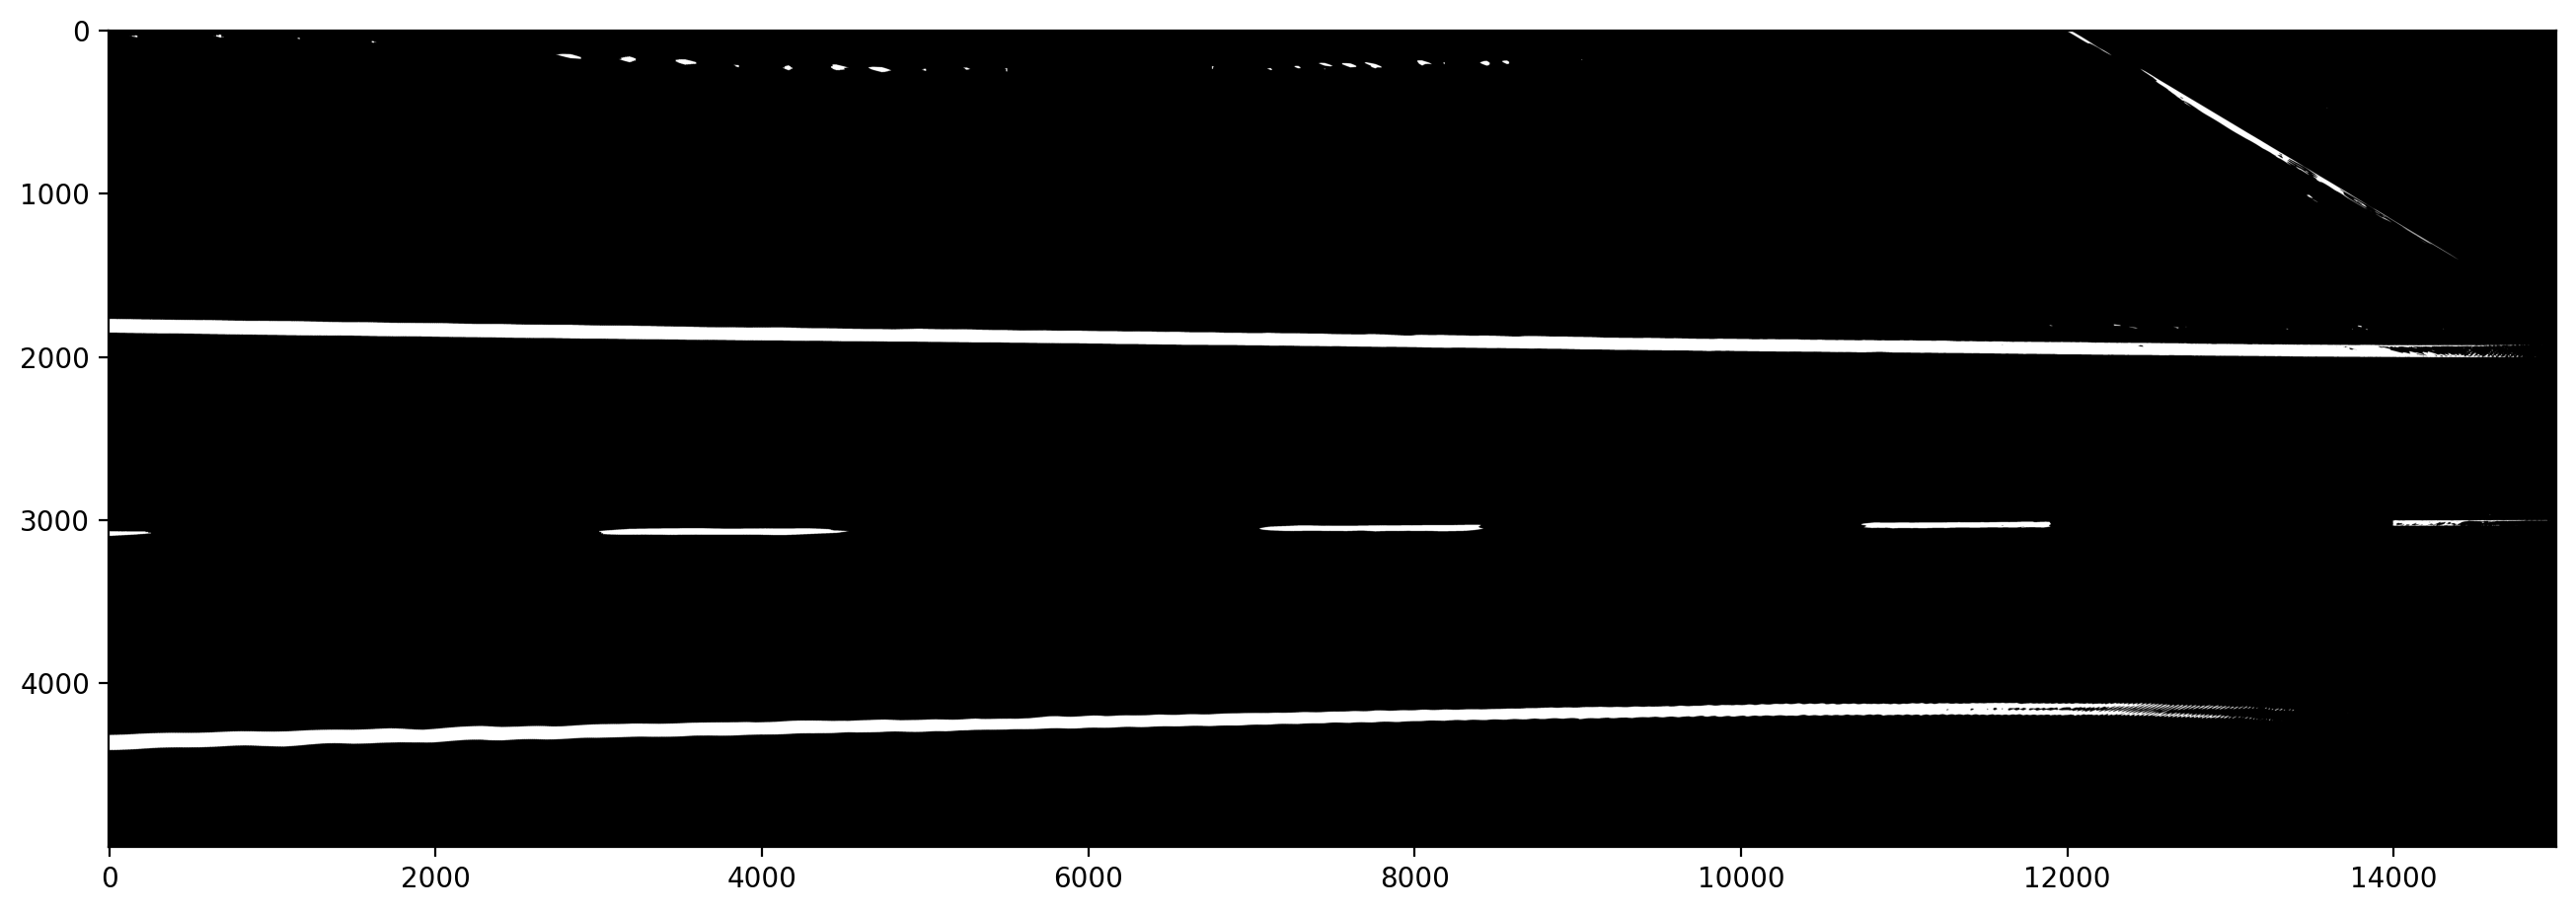

In [81]:
gray_bew = cv2.cvtColor(bew_frames[0], cv2.COLOR_BGR2GRAY)
# plt.imshow(gray_bew.T, cmap='gray')

ret, th1 = cv2.threshold(gray_bew, 180, 255, cv2.THRESH_BINARY)
print(th1.dtype)
plt.imshow(th1.T, cmap='gray')

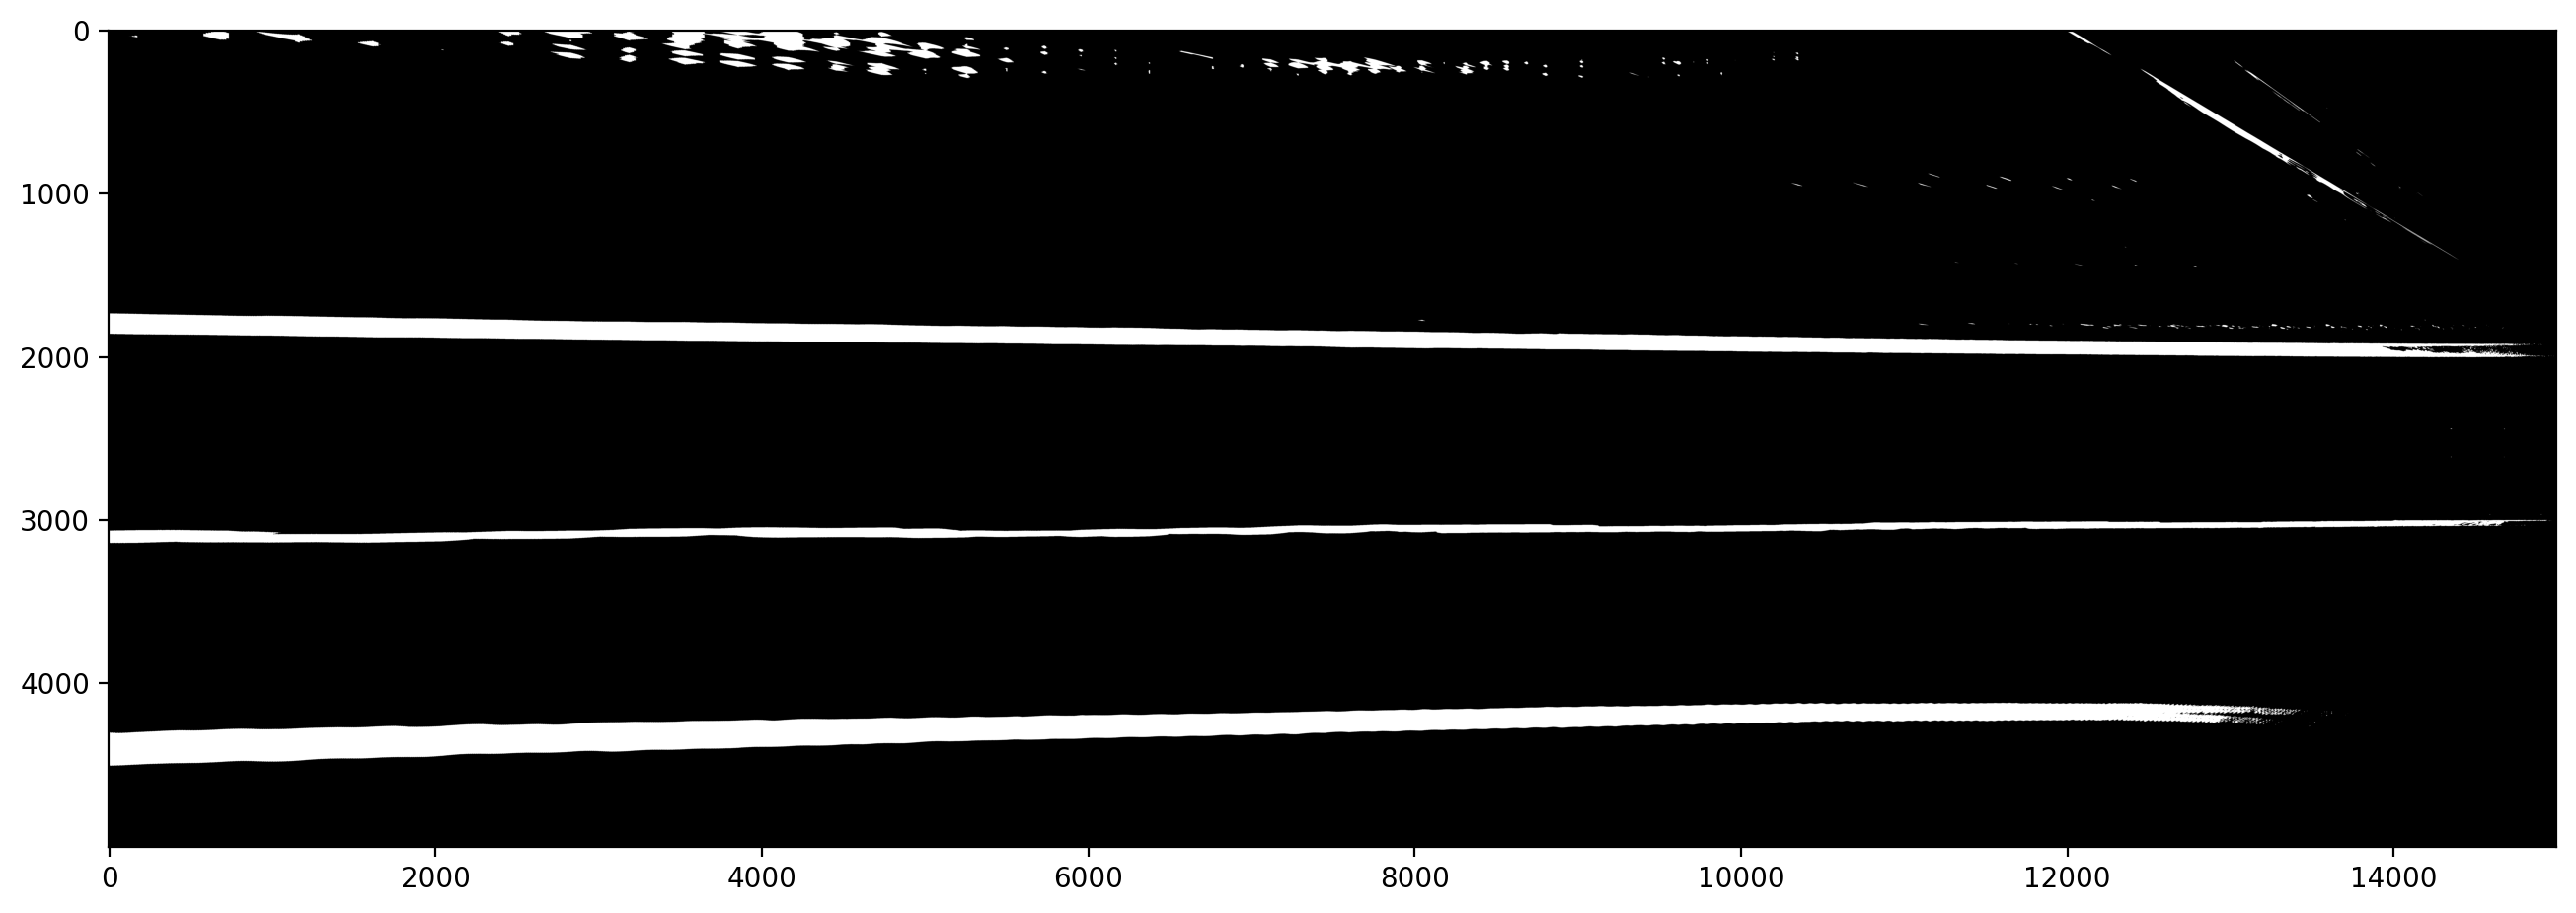

In [82]:
accumulated_frame = np.zeros_like(th1)

for bew_frame in bew_frames:
    gray_bew = cv2.cvtColor(bew_frame, cv2.COLOR_BGR2GRAY)
    ret, th1 = cv2.threshold(gray_bew, 180, 255, cv2.THRESH_BINARY)
    accumulated_frame = cv2.addWeighted(accumulated_frame, 1, th1, 1, 0)

plt.imshow(accumulated_frame.T, cmap='gray')

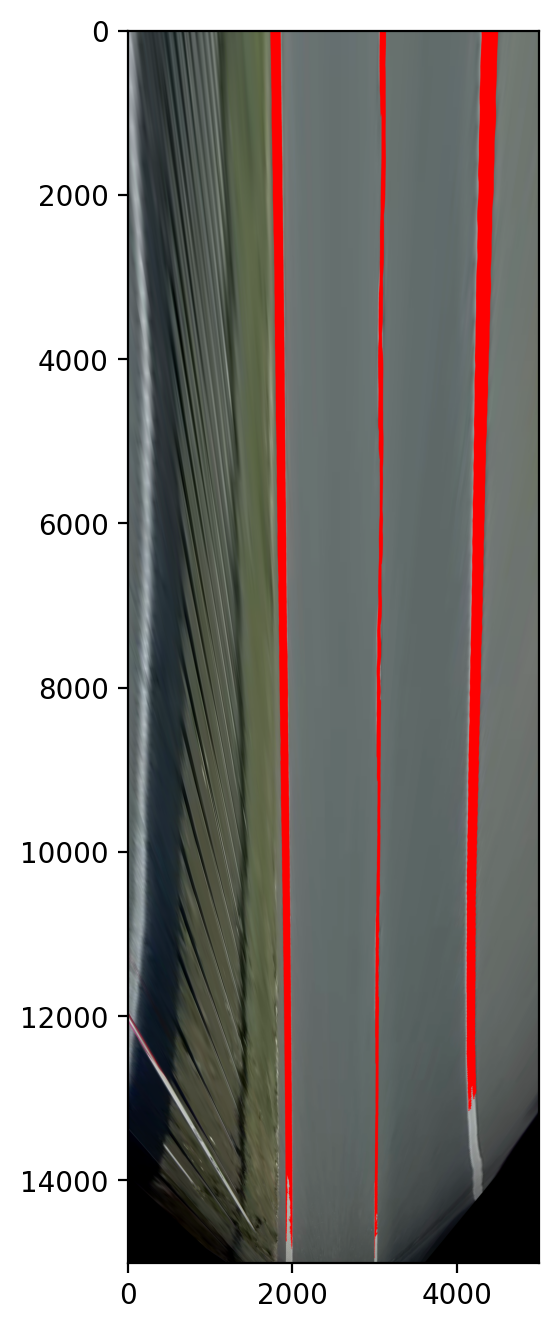

In [125]:
contours, hierarchy = cv2.findContours(accumulated_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

sorted_contours = sorted(contours, key=lambda c: cv2.contourArea(c), reverse=True)

selected_contours = sorted_contours[:3]

shapes_image = cv2.drawContours(np.copy(bew_frames[0]), selected_contours, -1, (255, 0, 0), -1)

plt.imshow(shapes_image)

In [144]:
lines_mask = []
lines_approx = []

sorted_x_contours = sorted(selected_contours, key=lambda contour: contour[0][0][0])

for contour in sorted_x_contours:
    mask = np.zeros_like(accumulated_frame)
    approx = np.zeros_like(accumulated_frame)

    cv2.drawContours(mask, [contour], -1, 255, -1)

    h, w = mask.shape

    y, x = np.nonzero(mask)

    x_values = np.linspace(0, w, 100)
    y_values = np.polyval(np.polyfit(x, y, 1), x_values)

    points = np.column_stack((x_values, y_values)).astype(np.int32)

    cv2.polylines(approx, [points], False, 255, 10)

    lines_mask.append(mask)
    lines_approx.append(approx)

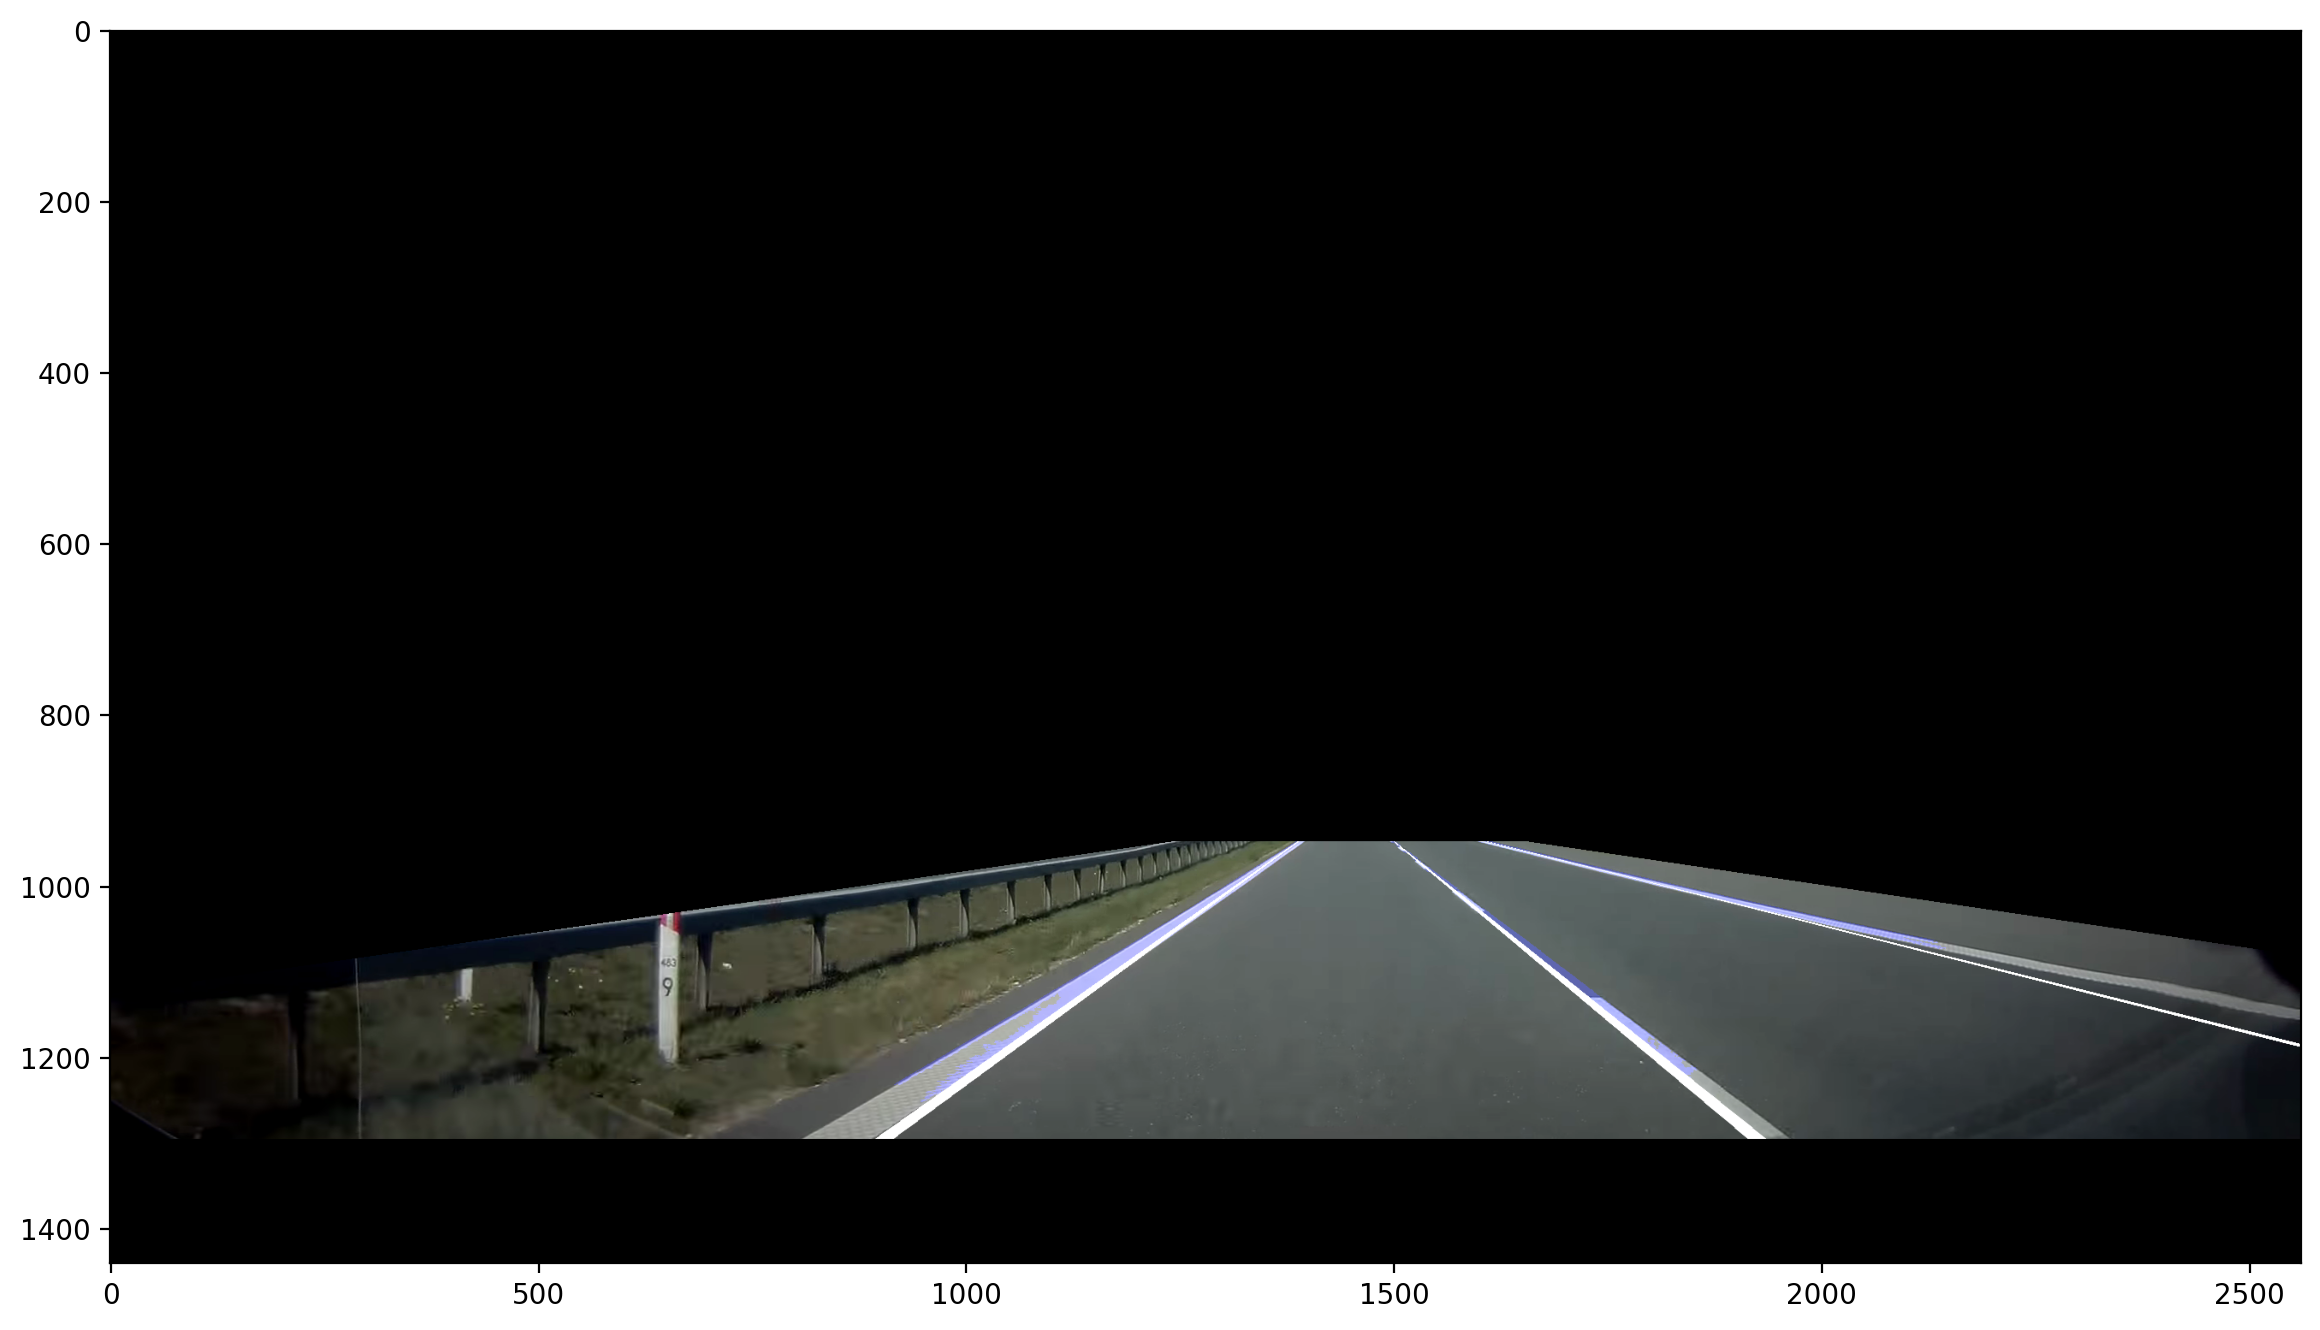

In [160]:
frame = np.copy(bew_frames[0])

for mask, approx in zip(lines_mask, lines_approx):
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    r,g,b = cv2.split(mask_rgb)
    mask_rgb = cv2.merge([r*0, g*0, b])

    frame = cv2.addWeighted(frame, 1, mask_rgb, 0.3, 0)

    approx_rgb = cv2.cvtColor(approx, cv2.COLOR_GRAY2BGR)

    frame = cv2.addWeighted(frame, 1, approx_rgb, 1, 0)

frame = pt.from_bird_eye_view(frame)

plt.imshow(frame)